# Long-short strategy using a Bagging Classifier with a Decision Tree Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
pd.set_option('use_inf_as_na', True)
from collections import Counter
pd.set_option('display.max_columns', None)
from scipy.cluster import hierarchy as hc
import scipy.stats

## Step 1

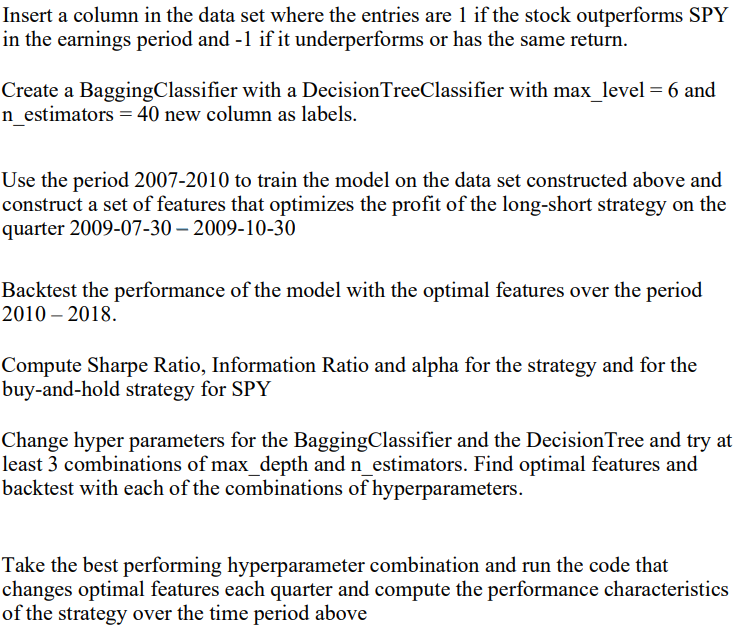

In [2]:
def baggingtree_feat_importance(m, df):
    feature_importances = []
    for est in m.estimators_:
        fi = est.feature_importances_
        feature_importances.append(fi)
    feature_importances = np.array(feature_importances)
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp':np.mean(feature_importances,axis=0)}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

def profit_importance(t,df,rets):
#     np.random.seed(123)
    profit = []
    for col in df.columns:
        prof = []
        for _ in range(20):
            X = df.copy()
            X[col] = np.random.permutation(df[col].values)
            prediction = t.predict(X)
            prof.append((prediction * rets).sum())
        profit.append(np.mean(prof))
    return profit

def baggingtree_profit_importance(m, df,rets):
    return pd.DataFrame({'cols':df.columns, 'pi_imp':profit_importance(m,df,rets)}
                       ).sort_values('pi_imp', ascending=True)

In [3]:
raw_data = pd.read_pickle(r'../../lecture2/dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)
# adding the labels
# note to self: these labels are different from the labels considered in class, we have -1, 1 instead of -1,0,1
data['rel_performance'] = np.where(data['pred_rel_return'] > 0, 1, -1)
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)

I will consider the following training period: 2006-04-30 -- 2009-04-30 and will use the quarter 2009-07-30 -- 2009-10-30 as the validation set.

In [4]:
df = data.loc['2006-04-30':'2009-04-30']
df_valid = data.loc['2009-07-30':'2009-10-30']

In [5]:
train = df.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)


valid = df_valid.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [6]:
train_stock_returns = df['next_period_return']
valid_stock_returns = df_valid['next_period_return']

In [7]:
y = df['rel_performance']
y_valid = df_valid['rel_performance']
y = y.values
y_valid = y_valid.values

In [8]:
# creating the hyperparameters list (max_depth, n_estimators)
max_depth_list = [4, 6, 8]
n_estimators_list = [20, 40 ,60]
hyperparams = []
for max_depth in max_depth_list:
    for n_estimators in n_estimators_list:
        hyperparams.append((max_depth, n_estimators))
hyperparams

[(4, 20),
 (4, 40),
 (4, 60),
 (6, 20),
 (6, 40),
 (6, 60),
 (8, 20),
 (8, 40),
 (8, 60)]

Below, for every combination of hyperparameters, I find the optimal features by removing features with zero feature_importance, and then features with smallest profit importance repeatedly. The quarter 2009-07-30 -- 2009-10-30 is used as the validation set.

Then, the model with optimal set of features is back tested. In the back test, the model is trained on a moving 3-year-long interval, which is lagging behind the test quarter by exactly one quarter. Finally, Sharpe Ratio, Information Ratio and alpha are computed.

In [9]:
start_dates = [pd.to_datetime('2006-10-01') + pd.DateOffset(months = 3 * i) for i in range(35)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]
training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

----------------------------------------------------------------------------


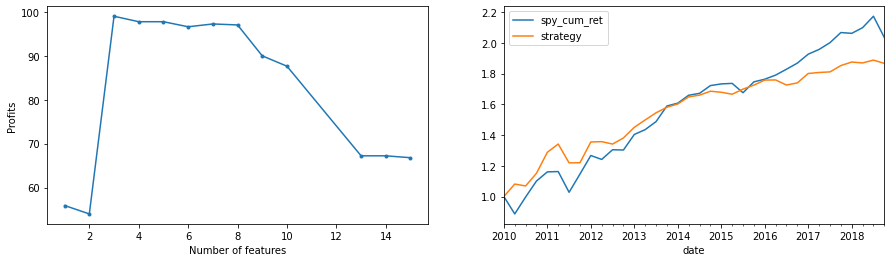

max_depth : 4
n_estimators : 20
optim_feats : ['fcf_yield' 'lctq4' 'ocf_lctq']
Strategy Sharpe Ratio : 1.3168083982075016
SPY Sharpe Ratio : 1.1411340547730477
Strategy total return : 1.865902782344698
SPY total return : 2.034179999999999
beta : 0.6338573328338537
IR : 0.4315308895386853
alpha : 0.015384740015452491
----------------------------------------------------------------------------
----------------------------------------------------------------------------


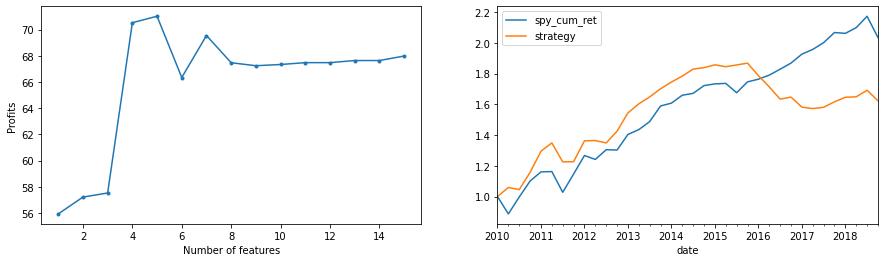

max_depth : 4
n_estimators : 40
optim_feats : ['ocf_lctq' 'actq' 'intcovq' 'cash_debtq' 'profit_lctq']
Strategy Sharpe Ratio : 0.3819721819771948
SPY Sharpe Ratio : 1.1411340547730477
Strategy total return : 1.6230158622886546
SPY total return : 2.034179999999999
beta : 0.6956728601671861
IR : -0.1761035621458042
alpha : -0.0229543193045314
----------------------------------------------------------------------------
----------------------------------------------------------------------------


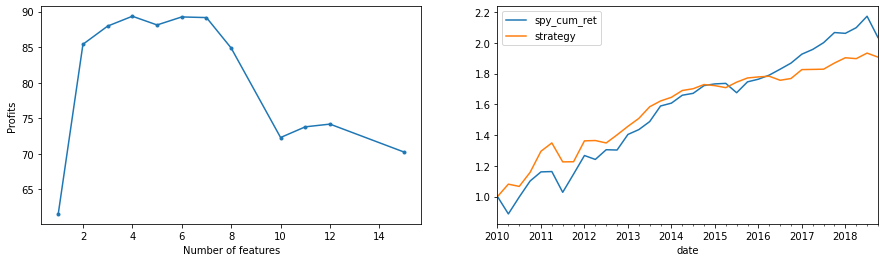

max_depth : 4
n_estimators : 60
optim_feats : ['ocf_lctq' 'fcf_yield' 'dpcy' 'profit_lctq']
Strategy Sharpe Ratio : 1.2622390768238423
SPY Sharpe Ratio : 1.1411340547730477
Strategy total return : 1.9066759987226898
SPY total return : 2.034179999999999
beta : 0.6197837234473333
IR : 0.4571722896757754
alpha : 0.02136172500683461
----------------------------------------------------------------------------
----------------------------------------------------------------------------


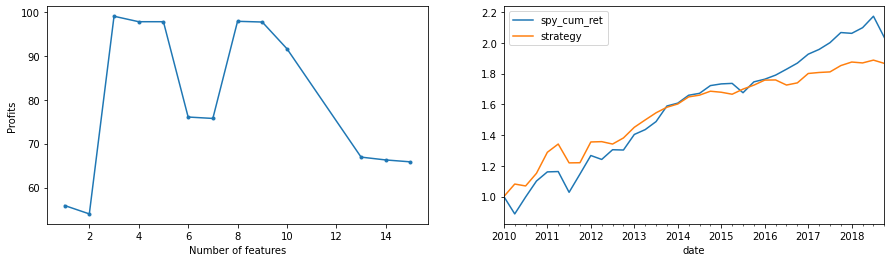

max_depth : 6
n_estimators : 20
optim_feats : ['fcf_yield' 'lctq4' 'ocf_lctq']
Strategy Sharpe Ratio : 1.3168083982075016
SPY Sharpe Ratio : 1.1411340547730477
Strategy total return : 1.865902782344698
SPY total return : 2.034179999999999
beta : 0.6338573328338537
IR : 0.4315308895386853
alpha : 0.015384740015452491
----------------------------------------------------------------------------
----------------------------------------------------------------------------


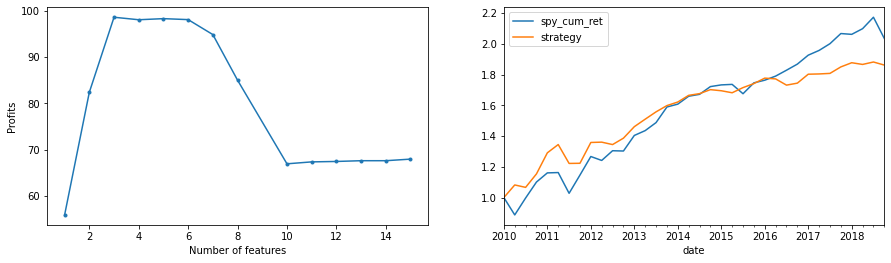

max_depth : 6
n_estimators : 40
optim_feats : ['fcf_yield' 'ocf_lctq' 'lctq4']
Strategy Sharpe Ratio : 1.2106462489088108
SPY Sharpe Ratio : 1.1411340547730477
Strategy total return : 1.8613495556589408
SPY total return : 2.034179999999999
beta : 0.6629398696620146
IR : 0.2725640348277259
alpha : 0.011080782898477626
----------------------------------------------------------------------------
----------------------------------------------------------------------------


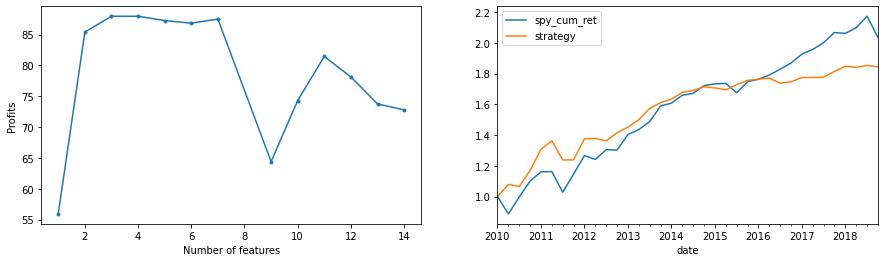

max_depth : 6
n_estimators : 60
optim_feats : ['ocf_lctq' 'fcf_yield' 'dpcy' 'debt_ebitdaq']
Strategy Sharpe Ratio : 1.1904151912037795
SPY Sharpe Ratio : 1.1411340547730477
Strategy total return : 1.843366336199072
SPY total return : 2.034179999999999
beta : 0.5320357586683847
IR : 0.44950586003505816
alpha : 0.022231921241293612
----------------------------------------------------------------------------
----------------------------------------------------------------------------


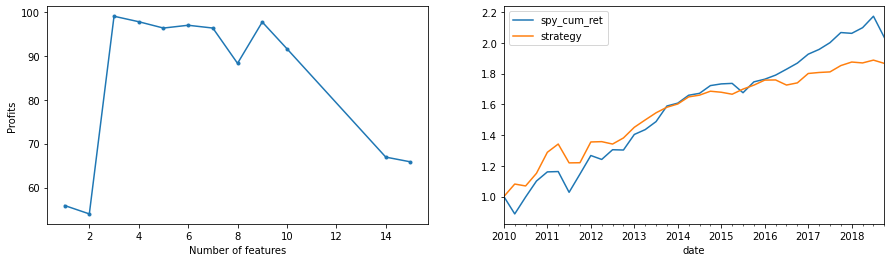

max_depth : 8
n_estimators : 20
optim_feats : ['fcf_yield' 'lctq4' 'ocf_lctq']
Strategy Sharpe Ratio : 1.3168083982075016
SPY Sharpe Ratio : 1.1411340547730477
Strategy total return : 1.865902782344698
SPY total return : 2.034179999999999
beta : 0.6338573328338537
IR : 0.4315308895386853
alpha : 0.015384740015452491
----------------------------------------------------------------------------
----------------------------------------------------------------------------


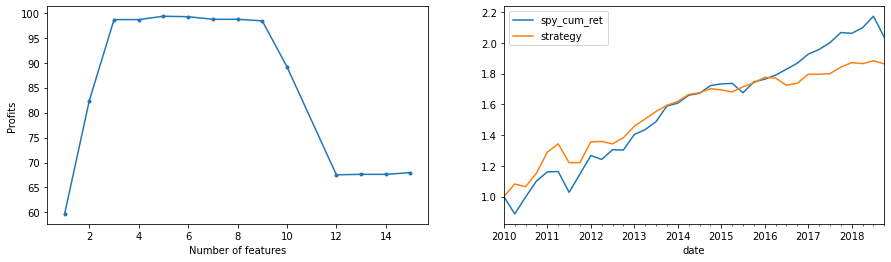

max_depth : 8
n_estimators : 40
optim_feats : ['fcf_yield' 'ocf_lctq' 'lctq4' 'lctq' 'profit_lctq']
Strategy Sharpe Ratio : 1.226180312463089
SPY Sharpe Ratio : 1.1411340547730477
Strategy total return : 1.8631505797484316
SPY total return : 2.034179999999999
beta : 0.6392814831597283
IR : 0.33735566578724385
alpha : 0.01428061380280052
----------------------------------------------------------------------------
----------------------------------------------------------------------------


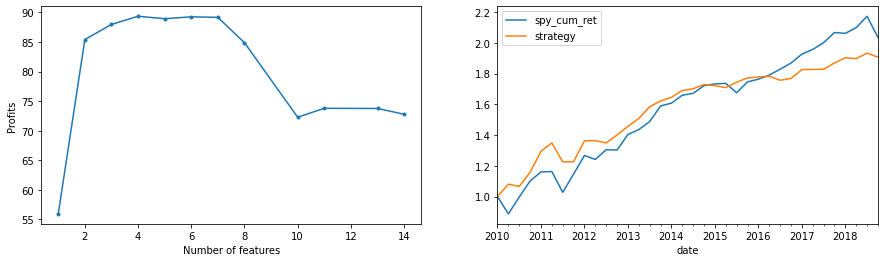

max_depth : 8
n_estimators : 60
optim_feats : ['ocf_lctq' 'fcf_yield' 'dpcy' 'profit_lctq']
Strategy Sharpe Ratio : 1.2622390768238423
SPY Sharpe Ratio : 1.1411340547730477
Strategy total return : 1.9066759987226898
SPY total return : 2.034179999999999
beta : 0.6197837234473333
IR : 0.4571722896757754
alpha : 0.02136172500683461
----------------------------------------------------------------------------


In [10]:
np.random.seed(123) # for replicable results


all_results = []
for max_depth, n_estimators in hyperparams:
    print("----------------------------------------------------------------------------")
    results = {}
    results['max_depth'] = max_depth
    results['n_estimators'] = n_estimators
    t_clf = DecisionTreeClassifier(max_depth=max_depth,min_samples_leaf=2400)
    # I will drop OOB score, it will not be used below anyway
    bg_clf = BaggingClassifier(t_clf,n_estimators=n_estimators,oob_score=False,random_state=1,n_jobs=-1)
    bg_clf.fit(train, y)
    fi = baggingtree_feat_importance(bg_clf,train)
    features = fi[(fi['feat_imp'] > 0.000)]
    train = train[features['cols'].values]
    valid = valid[features['cols'].values]

    profits = []

    feat=[]
    nfeat = []

    training = train.copy()
    validation = valid.copy()

    while len(training.columns)>1:

        bg_clf.fit(training,y)
        pi = baggingtree_profit_importance(bg_clf,validation,y_valid)

        col_to_drop = pi[pi['pi_imp'] == pi['pi_imp'].max()]['cols'].iloc[0]
        training.drop(col_to_drop,axis=1,inplace=True)
        validation.drop(col_to_drop,axis=1,inplace=True)
        bg_clf.fit(training,y)
        fi = baggingtree_feat_importance(bg_clf,training)
        features = fi[(fi['feat_imp'] > 0.00)]
        training = training[features['cols'].values]
        validation = validation[features['cols'].values]
        bg_clf.fit(training,y)
        pred_valid = bg_clf.predict(validation)
        profits.append((pred_valid * df_valid['next_period_return']).sum())
        nfeat.append(len(training.columns))
        feat.append(features['cols'].values) 

    

    n = np.argmax(profits)
    optim_feats = feat[n]
    max_profits = profits[n]
    results['optim_feats'] = optim_feats


    train_optim = train[optim_feats]
    valid_optim = valid[optim_feats]
    bg_clf.fit(train_optim,y)
    # print(bg_clf.score(train_optim,y))
    pred_valid_tree = bg_clf.predict(valid_optim)
    # print(bg_clf.score(valid_optim,y_valid))
    # (pred_valid_tree * y_valid).sum()


    # backtesting the model with optimal features
    opt_training_data = [t[optim_feats] for t in training_data]
    opt_test_data = [v[optim_feats] for v in test_data]

    P_L = []
    x = [1]
    ret = []

    for i in range(len(training_labels)):
            bg_clf.fit(opt_training_data[i],training_labels[i])
            pred_i = bg_clf.predict(opt_test_data[i])
            profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
            P_L.append(profit_i)
            num_positions = len(pred_i)
            ret.append((1.0/num_positions) * profit_i)
            x.append(x[i] + (x[i]/num_positions) * profit_i)

    # comparing with SPY
    SPY = pd.read_pickle(r'../../lecture2/SPY_cum_ret.pkl')
    SPY = SPY.loc['2010-01-01':]
    SPY = SPY.resample('Q').ffill()
    SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
    SPY['strategy'] = x
    
    fig, axs = plt.subplots(1,2, figsize=(15,4))
    axs[0].plot(nfeat, profits, '.-')
    axs[0].set_xlabel("Number of features")
    axs[0].set_ylabel("Profits")
    SPY.plot(ax=axs[1])
    plt.show()
    
    SPY = SPY.resample('Y').ffill()
#     SPY.plot();

    strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
    strategy_std = (SPY['strategy'] - 1).diff().std()
    strategy_sr = strategy_mean_ret/strategy_std
    results['Strategy Sharpe Ratio'] = strategy_sr
    (SPY['spy_cum_ret'] - 1).diff().mean()
    (SPY['spy_cum_ret'] - 1).diff().std()
    results['SPY Sharpe Ratio'] = (SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std()
    results['Strategy total return'] = x[-1]
    results['SPY total return'] = SPY['spy_cum_ret'][-1]

    strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
    spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

    beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
    results['beta'] = beta

    residual_ret = strategy_ret - beta * spy_ret
    IR = np.mean(residual_ret)/np.std(residual_ret)
    results['IR'] = IR

    alpha = np.mean(residual_ret)
    results['alpha'] = alpha
    for name, val in results.items():
        print(name, ":", val)
    print("----------------------------------------------------------------------------")
    all_results.append(results)

All the considered hyperparameter combinations lead to very similar results. The strategy underperfomrs SPY. I will choose the hyperparameter combination that results in the highest total return:

In [11]:
total_returns = [res['Strategy total return'] for res in all_results]
best_hyperparams_idx = np.argmax(total_returns)
print("Best hyperparams:")
best_res = all_results[best_hyperparams_idx]
best_res

Best hyperparams:


{'max_depth': 4,
 'n_estimators': 60,
 'optim_feats': array(['ocf_lctq', 'fcf_yield', 'dpcy', 'profit_lctq'], dtype=object),
 'Strategy Sharpe Ratio': 1.2622390768238423,
 'SPY Sharpe Ratio': 1.1411340547730477,
 'Strategy total return': 1.9066759987226898,
 'SPY total return': 2.034179999999999,
 'beta': 0.6197837234473333,
 'IR': 0.4571722896757754,
 'alpha': 0.02136172500683461}

At first I was surprised that the results above are so much worse than what we obtained in class (about 4-fold total return). But when I tried to run the above code on the full available period 2001-2018 (like we did in class), I obtained a 4-fold total return too. So I believe there is nothing horribly wrong with the code above. This is just really the best this strategy can do during 2012-2018.

## Running the code that changes optimal features every quarter

In [12]:
t_clf = DecisionTreeClassifier(max_depth=best_res['max_depth'],min_samples_leaf=2400)
# I will drop OOB score, it will not be used below anyway
bg_clf = BaggingClassifier(t_clf,n_estimators=best_res['n_estimators'],oob_score=False,random_state=1,n_jobs=-1)

In [13]:
start_dates = [pd.to_datetime('2006-07-01') + pd.DateOffset(months = 3 * i) for i in range(37)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

In [14]:
np.random.seed(123) # for replicable results
optimal_features = []

for i in range(len(training_data)):
    print(i)
    profits = []
    feat=[]

    bg_clf.fit(training_data[i],training_labels[i])
    fi = baggingtree_feat_importance(bg_clf,training_data[i])
    features = fi[fi['feat_imp'] > 0.005]
    
    train = training_data[i][features['cols'].values].copy()
    validation = test_data[i][features['cols'].values].copy()
    
    
    profits = []
    feat=[]
    
    bg_clf.fit(train,training_labels[i])
    
    while len(train.columns)>1:
        
        pi = baggingtree_profit_importance(bg_clf,validation,test_frames[i]['next_period_return'])

        col_to_drop = pi.iloc[-1]['cols']
        train.drop(col_to_drop,axis=1,inplace=True)
        validation.drop(col_to_drop,axis=1,inplace=True)
        
        bg_clf.fit(train,training_labels[i])
        pred_valid = bg_clf.predict(validation)
        profits.append((pred_valid * test_frames[i]['next_period_return']).sum())
        feat.append(train.columns)
        
    n = np.argmax(profits)

    max_profits = profits[n]

    optim_feats = feat[n]

    optimal_features.append(optim_feats)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


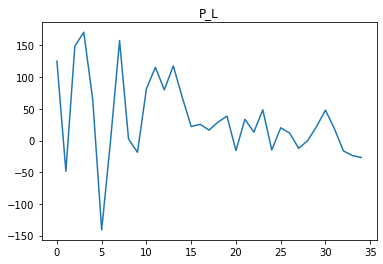

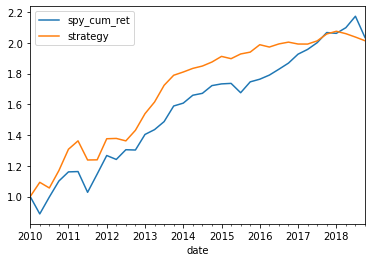

max_depth : 4
n_estimators : 60
Strategy Sharpe Ratio : 0.5332009237871321
SPY Sharpe Ratio : 0.46133385900210633
Strategy total return : 2.0131967612888926
SPY total return : 2.034179999999999
beta : 0.3083699936527166
IR : 0.3962524394786761
alpha : 0.019836762321517893


In [15]:
results = {}
results['max_depth'] = best_res['max_depth']
results['n_estimators'] = best_res['n_estimators']
P_L = []
x = [0,1]
ret = []

for i in range(1,len(optimal_features)-1):

        bg_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = bg_clf.predict(test_data[i][optimal_features[i-1]])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)
        
plt.plot(P_L)
plt.title("P_L")
plt.show()

SPY = pd.read_pickle(r'../../lecture2/SPY_cum_ret.pkl')
SPY = SPY.loc['2010-01-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]

SPY.plot()
plt.show()

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
results['Strategy Sharpe Ratio'] = strategy_sr
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
results['SPY Sharpe Ratio'] = (SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std()
results['Strategy total return'] = x[-1]
results['SPY total return'] = SPY['spy_cum_ret'][-1]

strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
results['beta'] = beta

residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
results['IR'] = IR

alpha = np.mean(residual_ret)
results['alpha'] = alpha
for name, val in results.items():
    print(name, ":", val)

## Step 2

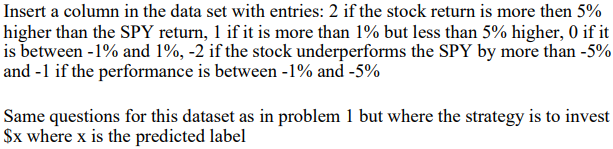

The only difference from Step 1 is the calculation of return.

In Step 1, I could use ```(prediction*test_frame['next_period_returm']).sum()/len(prediction)``` to calculate the quarterly return of the strategy. Because we would only have -1 or +1 (short or long) in ```prediction```. 

In Step 2, we need to use ```(prediction*test_frame['next_period_returm']).sum()/np.sum(np.abs(prediction))```, this will correctly take into account the fact that we long or short 2 times more of some tickers (with labels +-2) compared to some others (with labels +-1) (in dollar amount), and that we do not touch some tickers at all (the ones with label 0). 

In [16]:
# I adjusted definition of profit here compared to Problem 1
def baggingtree_feat_importance(m, df):
    feature_importances = []
    for est in m.estimators_:
        fi = est.feature_importances_
        feature_importances.append(fi)
    feature_importances = np.array(feature_importances)
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp':np.mean(feature_importances,axis=0)}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

def profit_importance(t,df,rets):
#     np.random.seed(123)
    profit = []
    for col in df.columns:
        prof = []
        for _ in range(20):
            X = df.copy()
            X[col] = np.random.permutation(df[col].values)
            prediction = t.predict(X)
            # with my adjustment here, it probably should be called return importance, not profit importance
            # but I'll keep the function name the way it is anyway.
            # The reason why I believe we need to compare return importance instead of profit importance, is because 
            # we actually want to maximize our profit at a fixed investment amount, that is, to maximize return.
            # In Problem 1 it was ok to maximize profit, because we always invested len(prediction) of dollars,
            # which was the same for all prediction vectors.
            # But in Problem 2, we invest np.sum(np.abs(prediction))) dollars, which is different for different
            # prediction vectors. It would be wrong to maximize profit, when the initial investment is not constant. 
            prof.append((prediction * rets).sum()/np.sum(np.abs(prediction)))
        profit.append(np.mean(prof))
    return profit

def baggingtree_profit_importance(m, df,rets):
    return pd.DataFrame({'cols':df.columns, 'pi_imp':profit_importance(m,df,rets)}
                       ).sort_values('pi_imp', ascending=True)

In [17]:
raw_data = pd.read_pickle(r'../../lecture2/dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)
# adding the labels
# auxiliary function
def f(x):
    absx = abs(x)
    signx = np.sign(x)
    if absx > 0.05:
        return signx*2
    elif absx > 0.01:
        return signx
    else:
        return 0
# adding the requested column
data['rel_performance'] = data['pred_rel_return'].apply(f).astype(int)
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)
data.head()

,ticker,actq,apq,atq,ceqq,cheq,cogsq,csh12q,cshfdq,cshiq,cshopq,cshoq,cshprq,cstkq,dlcq,dlttq,dpq,dvpq,epsf12,epsfi12,epsfiq,epsfxq,epspi12,epspiq,epspxq,epsx12,ibadj12,ibadjq,ibcomq,ibq,icaptq,invtq,lctq,ltq,mibq,miiq,niq,nopiq,oepf12,oeps12,oepsxq,oiadpq,oibdpq,opepsq,optdrq,piq,ppentq,prcraq,pstkq,pstkrq,rectq,req,revtq,saleq,seqq,spiq,teqq,txdbq,txditcq,txpq,txtq,xintq,xoprq,xrdq,xsgaq,capxy,cdvcy,chechy,cogsy,dlcchy,dltisy,dltry,dpcy,dvy,ibcomy,ibcy,miiy,oancfy,oepsxy,oibdpy,revty,txpdy,xidocy,xidoy,xinty,xrdy,xsgay,dvpspq,prccq,beq,bmq,book_value_per_share,book_value_yield,market_cap,buy_back_yield,yearly_sales,evmq,pe_op_basicq,pe_op_dilq,pe_exiq,capeiq,pe_incq,psq,oancfy_q,opcfq,cfo-per-share,cf_yield,pcfq,dvq,dprq,npmq,opmbdq,opmadq,gpmq,ptpmq,ibcq,dpcq,cfmq,at4,roaq,roceq,efftaxq,ceq4,seq4,lctq4,be4,lagbe4,lagseq4,lagicapt4,lagppent4,lagppent_alt4,roeq,aftret_eqq,aftret_invcapxq,aftret_equityq,pretret_noaq,pretret_earnatq,gprofq,equity_invcapq,debt_invcapq,totdebt_invcapq,capital_ratioq,int_debtq,int_totdebtq,cash_ltq,invt_actq,rect_actq,debt_atq,debt_ebitdaq,short_debtq,curr_debtq,lt_debtq,profit_lctq,ocf_lctq,capxq,fcf_ocfq,fcf_csfhdq,fcf_yield,cash_debtq,lt_ppentq,dltt_beq,debt_assetsq,debt_capitalq,de_ratioq,intcovq,intcov_ratioq,cash_ratioq,quick_ratioq,curr_ratioq,cash_conversionq,inv_turnq,at_turnq,rect_turnq,pay_turnq,sale_invcapq,sale_equityq,sale_nwcq,rd_saleq,at5,accrualq,return,cum_ret,spy_cum_ret,next_period_return,spy_next_period_return,pred_rel_return,fqtr_1,fqtr_2,fqtr_3,fqtr_4,sic_100,sic_200,sic_700,sic_800,sic_900,sic_1000,sic_1040,sic_1044,sic_1090,sic_1220,sic_1221,sic_1311,sic_1381,sic_1382,sic_1389,sic_1400,sic_1520,sic_1531,sic_1540,sic_1600,sic_1623,sic_1700,sic_1731,sic_2000,sic_2011,sic_2013,sic_2015,sic_2020,sic_2024,sic_2030,sic_2033,sic_2040,sic_2050,sic_2052,sic_2060,sic_2070,sic_2080,sic_2082,sic_2084,sic_2085,sic_2086,sic_2090,sic_2092,sic_2100,sic_2111,sic_2200,sic_2211,sic_2221,sic_2250,sic_2273,sic_2300,sic_2320,sic_2330,sic_2340,sic_2400,sic_2421,sic_2430,sic_2451,sic_2452,sic_2510,sic_2511,sic_2520,sic_2522,sic_2531,sic_2540,sic_2590,sic_2611,sic_2621,sic_2631,sic_2650,sic_2670,sic_2673,sic_2711,sic_2721,sic_2731,sic_2732,sic_2741,sic_2750,sic_2761,sic_2780,sic_2790,sic_2800,sic_2810,sic_2820,sic_2821,sic_2833,sic_2834,sic_2835,sic_2836,sic_2840,sic_2842,sic_2844,sic_2851,sic_2860,sic_2870,sic_2890,sic_2891,sic_2911,sic_2950,sic_2990,sic_3011,sic_3021,sic_3050,sic_3060,sic_3080,sic_3081,sic_3086,sic_3089,sic_3100,sic_3140,sic_3220,sic_3221,sic_3241,sic_3250,sic_3260,sic_3270,sic_3272,sic_3281,sic_3290,sic_3310,sic_3312,sic_3317,sic_3330,sic_3334,sic_3341,sic_3350,sic_3357,sic_3390,sic_3411,sic_3420,sic_3430,sic_3440,sic_3442,sic_3443,sic_3444,sic_3448,sic_3452,sic_3460,sic_3470,sic_3480,sic_3490,sic_3510,sic_3523,sic_3530,sic_3531,sic_3532,sic_3533,sic_3537,sic_3540,sic_3541,sic_3550,sic_3555,sic_3559,sic_3560,sic_3561,sic_3562,sic_3564,sic_3567,sic_3569,sic_3570,sic_3571,sic_3572,sic_3575,sic_3576,sic_3577,sic_3578,sic_3579,sic_3580,sic_3585,sic_3590,sic_3600,sic_3612,sic_3613,sic_3620,sic_3621,sic_3630,sic_3634,sic_3640,sic_3651,sic_3652,sic_3661,sic_3663,sic_3669,sic_3670,sic_3672,sic_3674,sic_3677,sic_3678,sic_3679,sic_3690,sic_3695,sic_3711,sic_3713,sic_3714,sic_3715,sic_3716,sic_3721,sic_3724,sic_3728,sic_3730,sic_3743,sic_3751,sic_3760,sic_3790,sic_3812,sic_3821,sic_3822,sic_3823,sic_3824,sic_3825,sic_3826,sic_3827,sic_3829,sic_3841,sic_3842,sic_3843,sic_3844,sic_3845,sic_3851,sic_3861,sic_3873,sic_3910,sic_3911,sic_3931,sic_3942,sic_3944,sic_3949,sic_3950,sic_3960,sic_3990,sic_4011,sic_4100,sic_4210,sic_4213,sic_4220,sic_4400,sic_4412,sic_4512,sic_4513,sic_4522,sic_4581,sic_4610,sic_4700,sic_4731,sic_4812,sic_4813,sic_4822,sic_4832,sic_4833,sic_4841,sic_4888,sic_4899,sic_4911,sic_4922,sic_4923,sic_4924,sic_4931,sic_4932,sic_4941,sic_4950,sic_4953,sic_4955,sic_4991,sic_5000,sic_5010,sic_5013,sic_5030,sic_5031,sic_5040,sic_5045,sic_5047,sic_5051,sic_5063,sic_5065,sic_5070,s

In [18]:
df = data.loc['2006-04-30':'2009-04-30']
df_valid = data.loc['2009-07-30':'2009-10-30']

In [19]:
train = df.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)


valid = df_valid.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [20]:
train_stock_returns = df['next_period_return']
valid_stock_returns = df_valid['next_period_return']

In [21]:
y = df['rel_performance']
y_valid = df_valid['rel_performance']
y = y.values
y_valid = y_valid.values

In [22]:
# creating the hyperparameters list (max_depth, n_estimators)
max_depth_list = [4, 6, 8]
n_estimators_list = [20, 40 ,60]
hyperparams = []
for max_depth in max_depth_list:
    for n_estimators in n_estimators_list:
        hyperparams.append((max_depth, n_estimators))
hyperparams

[(4, 20),
 (4, 40),
 (4, 60),
 (6, 20),
 (6, 40),
 (6, 60),
 (8, 20),
 (8, 40),
 (8, 60)]

Below, for every combination of hyperparameters, I find the optimal features by removing features with zero feature_importance, and then features with smallest return importance repeatedly. The quarter 2009-07-30 -- 2009-10-30 is used as the validation set.

Then, the model with optimal set of features is back tested. In the back test, the model is trained on a moving 3-year-long interval, which is lagging behind the test quarter by exactly one quarter. Finally, Sharpe Ratio, Information Ratio and alpha are computed.

In [23]:
start_dates = [pd.to_datetime('2006-10-01') + pd.DateOffset(months = 3 * i) for i in range(35)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]
training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

----------------------------------------------------------------------------


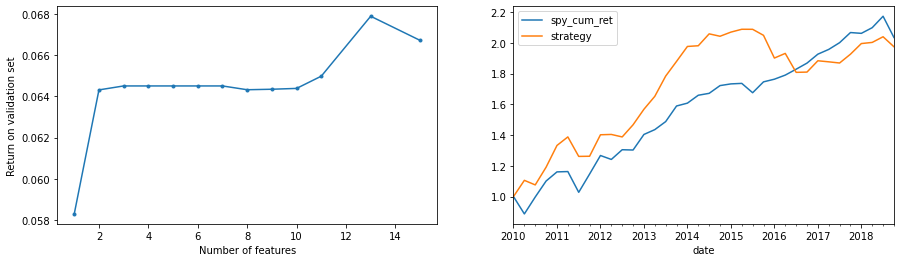

max_depth : 4
n_estimators : 20
optim_feats : ['cf_yield' 'dprq' 'oancfy' 'lctq4' 'actq' 'prccq' 'fqtr_2' 'gpmq'
 'debt_assetsq' 'dpcy' 'dvpspq' 'roeq' 'cash_ltq']
Strategy Sharpe Ratio : 0.5286234727202443
SPY Sharpe Ratio : 1.1411340547730477
Strategy total return : 1.9740162409764825
SPY total return : 2.034179999999999
beta : 1.1894416236790464
IR : -0.2869664180698181
alpha : -0.0408758389644848
----------------------------------------------------------------------------
----------------------------------------------------------------------------


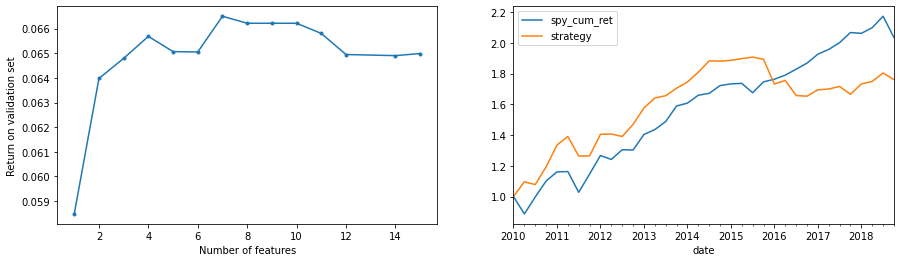

max_depth : 4
n_estimators : 40
optim_feats : ['cf_yield' 'oancfy' 'debt_assetsq' 'lctq4' 'gpmq' 'fqtr_2' 'dpcy']
Strategy Sharpe Ratio : 0.4688310815890322
SPY Sharpe Ratio : 1.1411340547730477
Strategy total return : 1.7602318144822575
SPY total return : 2.034179999999999
beta : 0.47175846298347013
IR : 0.11646473099357542
alpha : 0.01582254673747508
----------------------------------------------------------------------------
----------------------------------------------------------------------------


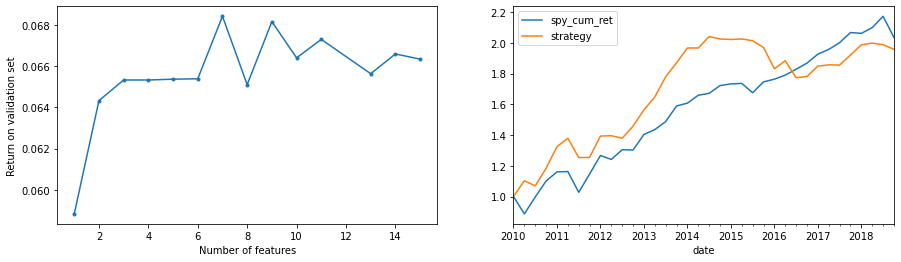

max_depth : 4
n_estimators : 60
optim_feats : ['cf_yield' 'oancfy' 'prccq' 'lctq4' 'dvpspq' 'gpmq' 'cash_ltq']
Strategy Sharpe Ratio : 0.5399043168656035
SPY Sharpe Ratio : 1.1411340547730477
Strategy total return : 1.9574301442383386
SPY total return : 2.034179999999999
beta : 1.3350145640953408
IR : -0.4692051444161856
alpha : -0.05904447548237277
----------------------------------------------------------------------------
----------------------------------------------------------------------------


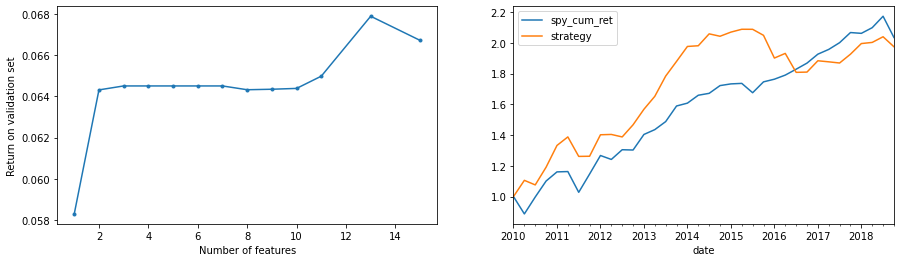

max_depth : 6
n_estimators : 20
optim_feats : ['cf_yield' 'dprq' 'oancfy' 'lctq4' 'actq' 'prccq' 'fqtr_2' 'gpmq'
 'debt_assetsq' 'dpcy' 'dvpspq' 'roeq' 'cash_ltq']
Strategy Sharpe Ratio : 0.5286234727202443
SPY Sharpe Ratio : 1.1411340547730477
Strategy total return : 1.9740162409764825
SPY total return : 2.034179999999999
beta : 1.1894416236790464
IR : -0.2869664180698181
alpha : -0.0408758389644848
----------------------------------------------------------------------------
----------------------------------------------------------------------------


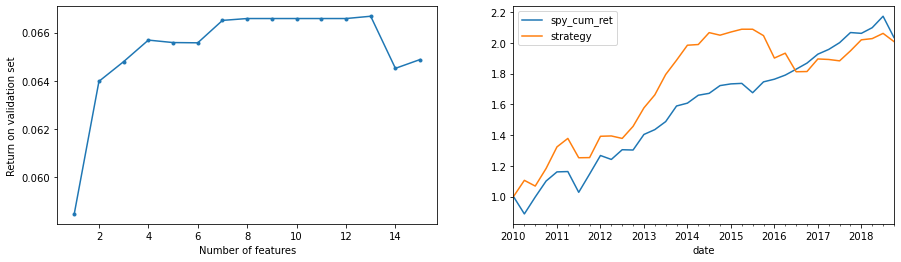

max_depth : 6
n_estimators : 40
optim_feats : ['cf_yield' 'dprq' 'oancfy' 'lctq4' 'debt_assetsq' 'prccq' 'fqtr_2' 'dpcy'
 'gpmq' 'debt_ebitdaq' 'dvpspq' 'roeq' 'cash_ltq']
Strategy Sharpe Ratio : 0.5469779084412614
SPY Sharpe Ratio : 1.1411340547730477
Strategy total return : 2.007820650155558
SPY total return : 2.034179999999999
beta : 1.2447838981611647
IR : -0.2939402877446954
alpha : -0.04206679969951152
----------------------------------------------------------------------------
----------------------------------------------------------------------------


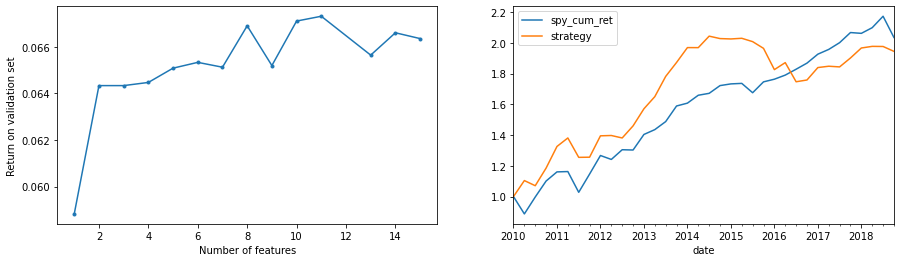

max_depth : 6
n_estimators : 60
optim_feats : ['cf_yield' 'oancfy' 'prccq' 'debt_ebitdaq' 'lctq4' 'dvpspq' 'actq'
 'fqtr_2' 'gpmq' 'cash_ltq' 'dpcy']
Strategy Sharpe Ratio : 0.5151736640113631
SPY Sharpe Ratio : 1.1411340547730477
Strategy total return : 1.9440398304330546
SPY total return : 2.034179999999999
beta : 1.3371742329683063
IR : -0.4634260105007944
alpha : -0.06112711517306335
----------------------------------------------------------------------------
----------------------------------------------------------------------------


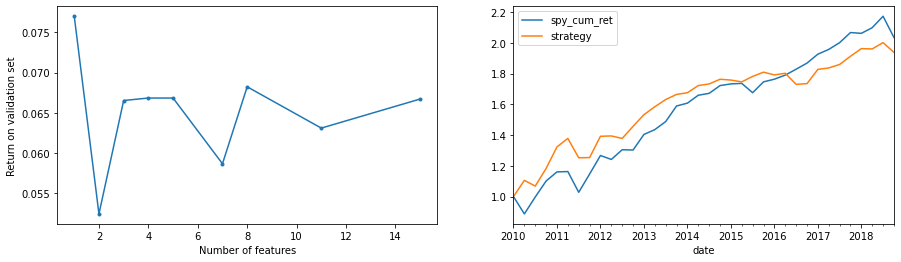

max_depth : 8
n_estimators : 20
optim_feats : ['fcf_yield']
Strategy Sharpe Ratio : 0.9576762542409805
SPY Sharpe Ratio : 1.1411340547730477
Strategy total return : 1.937301704085873
SPY total return : 2.034179999999999
beta : 0.7195114854969682
IR : 0.14785300111342012
alpha : 0.01038866695794143
----------------------------------------------------------------------------
----------------------------------------------------------------------------


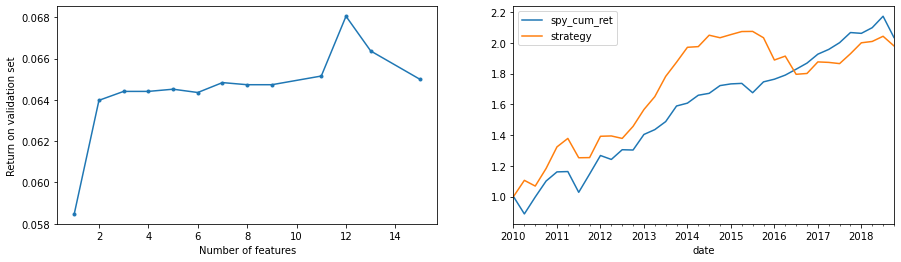

max_depth : 8
n_estimators : 40
optim_feats : ['cf_yield' 'dprq' 'oancfy' 'debt_assetsq' 'actq' 'prccq' 'lctq4' 'gpmq'
 'debt_ebitdaq' 'dvpspq' 'roeq' 'cash_ltq']
Strategy Sharpe Ratio : 0.5388963757660498
SPY Sharpe Ratio : 1.1411340547730477
Strategy total return : 1.9796860786802637
SPY total return : 2.034179999999999
beta : 1.219811191629994
IR : -0.30405368820294504
alpha : -0.04267068290218323
----------------------------------------------------------------------------
----------------------------------------------------------------------------


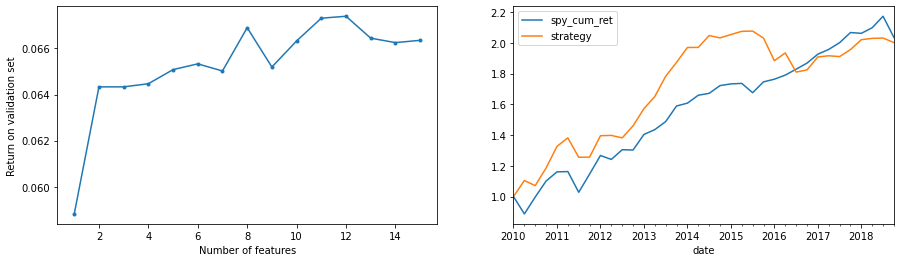

max_depth : 8
n_estimators : 60
optim_feats : ['cf_yield' 'oancfy' 'prccq' 'debt_assetsq' 'debt_ebitdaq' 'lctq4'
 'dvpspq' 'actq' 'fqtr_2' 'gpmq' 'cash_ltq' 'dpcy']
Strategy Sharpe Ratio : 0.5734213867740178
SPY Sharpe Ratio : 1.1411340547730477
Strategy total return : 2.0011499497521763
SPY total return : 2.034179999999999
beta : 1.228790583463323
IR : -0.314984187848117
alpha : -0.041414947905328674
----------------------------------------------------------------------------


In [24]:
np.random.seed(123) # for replicable results


all_results = []
for max_depth, n_estimators in hyperparams:
    print("----------------------------------------------------------------------------")
    results = {}
    results['max_depth'] = max_depth
    results['n_estimators'] = n_estimators
    t_clf = DecisionTreeClassifier(max_depth=max_depth,min_samples_leaf=2400)
    # I will drop OOB score, it will not be used below anyway
    bg_clf = BaggingClassifier(t_clf,n_estimators=n_estimators,oob_score=False,random_state=1,n_jobs=-1)
    bg_clf.fit(train, y)
    fi = baggingtree_feat_importance(bg_clf,train)
    features = fi[(fi['feat_imp'] > 0.000)]
    train = train[features['cols'].values]
    valid = valid[features['cols'].values]

    profits = []

    feat=[]
    nfeat = []

    training = train.copy()
    validation = valid.copy()

    while len(training.columns)>1:

        bg_clf.fit(training,y)
        pi = baggingtree_profit_importance(bg_clf,validation,y_valid)

        col_to_drop = pi[pi['pi_imp'] == pi['pi_imp'].max()]['cols'].iloc[0]
        training.drop(col_to_drop,axis=1,inplace=True)
        validation.drop(col_to_drop,axis=1,inplace=True)
        bg_clf.fit(training,y)
        fi = baggingtree_feat_importance(bg_clf,training)
        features = fi[(fi['feat_imp'] > 0.00)]
        training = training[features['cols'].values]
        validation = validation[features['cols'].values]
        bg_clf.fit(training,y)
        pred_valid = bg_clf.predict(validation)
        profits.append((pred_valid * df_valid['next_period_return']).sum()/np.sum(np.abs(pred_valid)))
        nfeat.append(len(training.columns))
        feat.append(features['cols'].values) 

    

    n = np.argmax(profits)
    optim_feats = feat[n]
    max_profits = profits[n]
    results['optim_feats'] = optim_feats


    train_optim = train[optim_feats]
    valid_optim = valid[optim_feats]
    bg_clf.fit(train_optim,y)
    # print(bg_clf.score(train_optim,y))
    pred_valid_tree = bg_clf.predict(valid_optim)
    # print(bg_clf.score(valid_optim,y_valid))
    # (pred_valid_tree * y_valid).sum()


    # backtesting the model with optimal features
    opt_training_data = [t[optim_feats] for t in training_data]
    opt_test_data = [v[optim_feats] for v in test_data]

    P_L = []
    x = [1]
    ret = []

    for i in range(len(training_labels)):
            bg_clf.fit(opt_training_data[i],training_labels[i])
            pred_i = bg_clf.predict(opt_test_data[i])
            profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
            P_L.append(profit_i)
            num_positions = np.sum(np.abs(pred_i))
            ret.append((1.0/num_positions) * profit_i)
            x.append(x[i] + (x[i]/num_positions) * profit_i)

    # comparing with SPY
    SPY = pd.read_pickle(r'../../lecture2/SPY_cum_ret.pkl')
    SPY = SPY.loc['2010-01-01':]
    SPY = SPY.resample('Q').ffill()
    SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
    SPY['strategy'] = x
    
    fig, axs = plt.subplots(1,2, figsize=(15,4))
    axs[0].plot(nfeat, profits, '.-')
    axs[0].set_xlabel("Number of features")
    axs[0].set_ylabel("Return on validation set")
    SPY.plot(ax=axs[1])
    plt.show()
    
    SPY = SPY.resample('Y').ffill()
#     SPY.plot();

    strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
    strategy_std = (SPY['strategy'] - 1).diff().std()
    strategy_sr = strategy_mean_ret/strategy_std
    results['Strategy Sharpe Ratio'] = strategy_sr
    (SPY['spy_cum_ret'] - 1).diff().mean()
    (SPY['spy_cum_ret'] - 1).diff().std()
    results['SPY Sharpe Ratio'] = (SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std()
    results['Strategy total return'] = x[-1]
    results['SPY total return'] = SPY['spy_cum_ret'][-1]

    strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
    spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

    beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
    results['beta'] = beta

    residual_ret = strategy_ret - beta * spy_ret
    IR = np.mean(residual_ret)/np.std(residual_ret)
    results['IR'] = IR

    alpha = np.mean(residual_ret)
    results['alpha'] = alpha
    for name, val in results.items():
        print(name, ":", val)
    print("----------------------------------------------------------------------------")
    all_results.append(results)

In [25]:
total_returns = [res['Strategy total return'] for res in all_results]
best_hyperparams_idx = np.argmax(total_returns)
print("Best hyperparams:")
best_res = all_results[best_hyperparams_idx]
best_res

Best hyperparams:


{'max_depth': 6,
 'n_estimators': 40,
 'optim_feats': array(['cf_yield', 'dprq', 'oancfy', 'lctq4', 'debt_assetsq', 'prccq',
        'fqtr_2', 'dpcy', 'gpmq', 'debt_ebitdaq', 'dvpspq', 'roeq',
        'cash_ltq'], dtype=object),
 'Strategy Sharpe Ratio': 0.5469779084412614,
 'SPY Sharpe Ratio': 1.1411340547730477,
 'Strategy total return': 2.007820650155558,
 'SPY total return': 2.034179999999999,
 'beta': 1.2447838981611647,
 'IR': -0.2939402877446954,
 'alpha': -0.04206679969951152}

## Running the code that changes optimal features every quarter

In [26]:
t_clf = DecisionTreeClassifier(max_depth=best_res['max_depth'],min_samples_leaf=2400)
# I will drop OOB score, it will not be used below anyway
bg_clf = BaggingClassifier(t_clf,n_estimators=best_res['n_estimators'],oob_score=False,random_state=1,n_jobs=-1)

In [27]:
start_dates = [pd.to_datetime('2006-07-01') + pd.DateOffset(months = 3 * i) for i in range(37)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

In [28]:
np.random.seed(123) # for replicable results
optimal_features = []

for i in range(len(training_data)):
    print(i)
    profits = []
    feat=[]

    bg_clf.fit(training_data[i],training_labels[i])
    fi = baggingtree_feat_importance(bg_clf,training_data[i])
    features = fi[fi['feat_imp'] > 0.005]
    
    train = training_data[i][features['cols'].values].copy()
    validation = test_data[i][features['cols'].values].copy()
    
    
    profits = []
    feat=[]
    
    bg_clf.fit(train,training_labels[i])
    
    while len(train.columns)>1:
        
        pi = baggingtree_profit_importance(bg_clf,validation,test_frames[i]['next_period_return'])

        col_to_drop = pi.iloc[-1]['cols']
        train.drop(col_to_drop,axis=1,inplace=True)
        validation.drop(col_to_drop,axis=1,inplace=True)
        
        bg_clf.fit(train,training_labels[i])
        pred_valid = bg_clf.predict(validation)
        profits.append((pred_valid * test_frames[i]['next_period_return']).sum()/np.sum(np.abs(pred_valid)))
        feat.append(train.columns)
        
    n = np.argmax(profits)

    max_profits = profits[n]

    optim_feats = feat[n]

    optimal_features.append(optim_feats)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


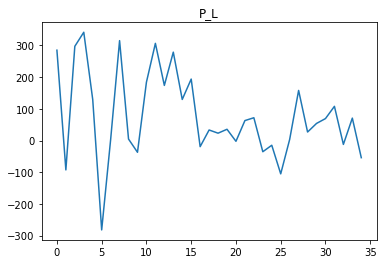

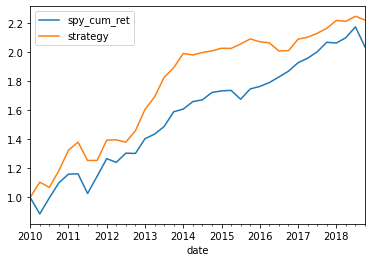

max_depth : 6
n_estimators : 40
Strategy Sharpe Ratio : 0.5673849428054829
SPY Sharpe Ratio : 0.46133385900210633
Strategy total return : 2.218782464984736
SPY total return : 2.034179999999999
beta : 0.34608468600153863
IR : 0.4341913511480894
alpha : 0.024596245840447572


In [29]:
results = {}
results['max_depth'] = best_res['max_depth']
results['n_estimators'] = best_res['n_estimators']
P_L = []
x = [0,1]
ret = []

for i in range(1,len(optimal_features)-1):

        bg_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = bg_clf.predict(test_data[i][optimal_features[i-1]])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = np.sum(np.abs(pred_i))
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)
        
plt.plot(P_L)
plt.title("P_L")
plt.show()

SPY = pd.read_pickle(r'../../lecture2/SPY_cum_ret.pkl')
SPY = SPY.loc['2010-01-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]

SPY.plot()
plt.show()

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
results['Strategy Sharpe Ratio'] = strategy_sr
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
results['SPY Sharpe Ratio'] = (SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std()
results['Strategy total return'] = x[-1]
results['SPY total return'] = SPY['spy_cum_ret'][-1]

strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
results['beta'] = beta

residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
results['IR'] = IR

alpha = np.mean(residual_ret)
results['alpha'] = alpha
for name, val in results.items():
    print(name, ":", val)

Here I think it's important to note that the plot for Profit as a function of time (P_L) is the profit which one would get in each quarter after invesring \$x dollars in each ticker, where x is the label. But this is not indicative of the actual return per quarter, because the total amount of money invested in such consideration is different depending on the relative amount of +-1's,  +-2's, and 0's in ```prediction``` 

This strategy performs better than what I got in Step 1. At least this one outperforms SPY by a little bit.